# Capstone 2: Narrative Analytics and Experimentation

### Dataset
This dataset is provided by Brian Ho, found at https://github.com/kimusu2008/SPSS_Example1

### Problem
An unnamed spanish worldwide ecommerce website has localized versions of its website (Spain, Argentina, Mexico, etc.). The managers notied that the spain-based users had a higher conversion rate than other spanish speaking countries, and so the international languages team wants to try translating the pages into the localized versions by locals of those spanish speaking countries - instead of having one translator do all versions (the translator was from Spain).

### Experimental Design
Two groups of users would interface with two versions of the website: one with the new, more localized translation (by a local Spanish speaker) versus the old website which was written by a Spainiard. We will check to see if conversions will increase (the number of sign-ups).

### Hypothesis
A localized translation will increase conversions in their respective countries rather than the generic Spain-spanish version.

### Metric
The number of conversions - the number of customers who sign up for the e-commerce website.

### Packages and Importing our Data

Let's take a look at our data for analysis:

In [16]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy import stats

import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [17]:
test_df = pd.read_csv(r'C:\Users\edcha\Documents\Work Files\Thinkful Data Science Bootcamp\Capstone 2\SPSS_Example1-master\test_table.csv')
user_df = pd.read_csv(r'C:\Users\edcha\Documents\Work Files\Thinkful Data Science Bootcamp\Capstone 2\SPSS_Example1-master\user_table.csv')

In [18]:
df = pd.merge(test_df, user_df, how = 'inner', on = 'user_id')
del test_df, user_df # save memory

## EDA

In [19]:
df.sample(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
301349,421066,2015-12-04,SEO,Mobile,Other,NaN,Iphone_App,0,1,F,25,Mexico
63425,267971,2015-12-01,Ads,Mobile,ES,Yahoo,Android_App,1,1,M,44,Colombia
241686,125319,2015-11-30,Direct,Mobile,ES,NaN,Iphone_App,0,0,M,33,Guatemala
228353,461645,2015-12-04,Ads,Web,ES,Google,Chrome,0,0,M,25,Mexico
26361,26120,2015-11-30,SEO,Web,ES,NaN,Safari,0,1,F,40,Mexico


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452867 entries, 0 to 452866
Data columns (total 12 columns):
user_id             452867 non-null int64
date                452867 non-null object
source              452867 non-null object
device              452867 non-null object
browser_language    452867 non-null object
ads_channel         181693 non-null object
browser             452867 non-null object
conversion          452867 non-null int64
test                452867 non-null int64
sex                 452867 non-null object
age                 452867 non-null int64
country             452867 non-null object
dtypes: int64(4), object(8)
memory usage: 44.9+ MB


In [21]:
# Drop unneeded columns
df.drop(['user_id', 'source', 'device', 'browser_language', 'ads_channel', 'browser', 'sex', 'age'], axis = 1, inplace = True)

Let's summarize our data by country and the results of the test group and the control groups (test = 0 for control and test = 1 for treatment group):

### Data Wrangling

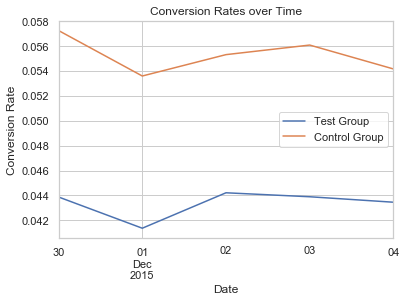

In [22]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)

# Plot our data - test versus control
f = df[df.test==1][['date','conversion']].groupby('date').mean().plot()
df[df.test==0][['date', 'conversion']].groupby('date').mean().plot(ax=f)
plt.legend(['Test Group', 'Control Group'])
plt.title('Conversion Rates over Time')
plt.ylabel('Conversion Rate')
plt.xlabel('Date')
plt.show()

We notice something strange here...something doesn't seem quite write. Let's take a look at our groups. We may have a perfect example here of simpson's paradox!

In [42]:
# Create two tables - one with counts of sample size for control/treatment, and the other with total conversions
sample_size = df.groupby(['country', 'test'], as_index = False).count()
conversions = df.groupby(['country', 'test'], as_index = False).sum()
df_summary = pd.merge(sample_size, conversions, on = ['country', 'test'])

# Rename columns and add a ratio column
df_summary.rename(columns ={'conversion_x':'sample_size', 'conversion_y':'conversions'}, inplace = True)
df_summary['conversion_ratio'] = df_summary.conversions / df_summary.sample_size
df_summary.drop(columns = ['date'])

,country,test,sample_size,conversions,conversion_ratio
0,Argentina,0,9356,141,0.015071
1,Argentina,1,37377,513,0.013725
2,Bolivia,0,5550,274,0.049369
3,Bolivia,1,5574,267,0.047901
4,Chile,0,9853,474,0.048107
5,Chile,1,9884,507,0.051295
6,Colombia,0,27088,1411,0.052089
7,Colombia,1,26972,1364,0.050571
8,Costa Rica,0,2660,139,0.052256
9,Costa Rica,1,2649,145,0.054738


We will probably remove observations from Spain, Uruguay, and Argentina since the observations are so low and would bias our results in our testing.

In [54]:
# Set Country as Index for our dataframes
df_summary.set_index('country', inplace = True)
df.set_index('country', inplace = True)

# Remove Spain, Uruguay, and Argentina
df_summary.drop(['Spain', 'Uruguay', 'Argentina'], inplace = True)
df.drop(['Spain', 'Uruguay', 'Argentina'], inplace = True)

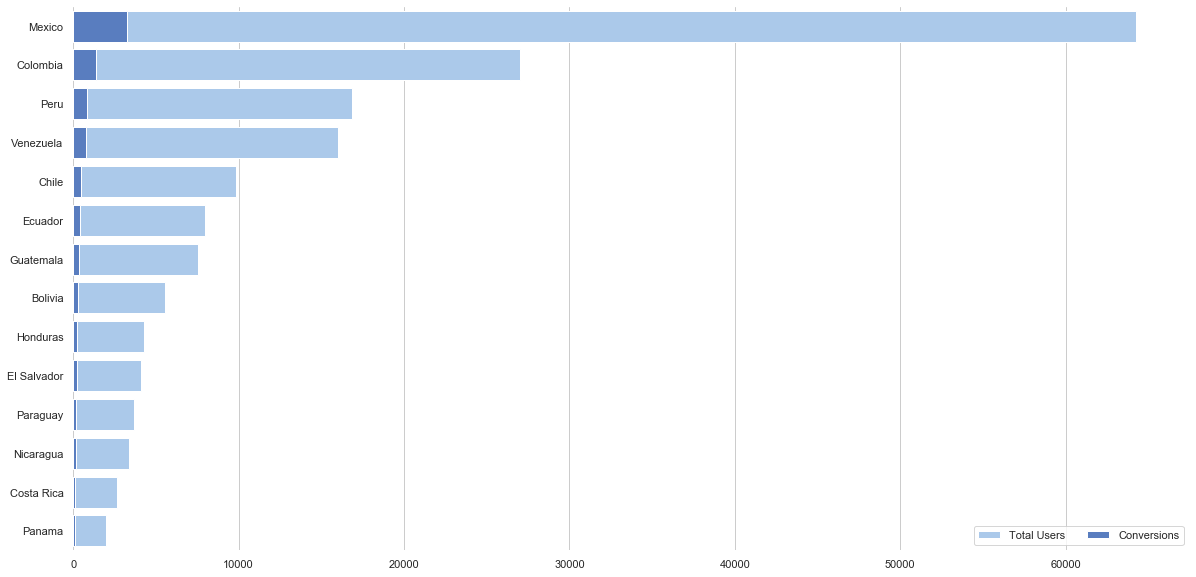

In [63]:
# Visual representation of our table above
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(20, 10))
df_summary_sorted = df_summary.sort_values('sample_size', ascending = False)

# Plot total - sample sizes
sns.set_color_codes('pastel')
sns.barplot(data = df_summary_sorted.reset_index(), x = 'sample_size', y = 'country', label = 'Total Users', color = 'b', ci = None)

# Plot the conversions
sns.set_color_codes('muted')
sns.barplot(data = df_summary_sorted.reset_index(), x = 'conversions', y = 'country', label = 'Conversions', color = 'b', ci = None)

# Add a legend
ax.legend(ncol=2, loc='lower right', frameon=True)
ax.set(xlabel='', ylabel='')
sns.despine(left=True, bottom=True)
plt.show()

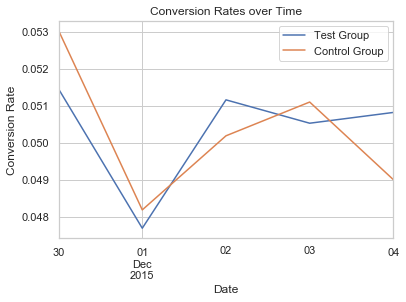

In [77]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)

# Plot our data - test versus control
f = df[df.test==1][['date','conversion']].groupby('date').mean().plot()
df[df.test==0][['date', 'conversion']].groupby('date').mean().plot(ax=f)
plt.legend(['Test Group', 'Control Group'])
plt.title('Conversion Rates over Time')
plt.ylabel('Conversion Rate')
plt.xlabel('Date')
plt.show()

From our graph, we note that conversions between our test group and control group are quite similar over the 5 days. There is some fluctuation between the 2nd and 4th of December, and this might be a sign of our the results of our treatment group in regards to conversions.

### T-test
Let's see if our experimemnt is significant based off our data:

In [12]:
# Size of each group
print('Test Sample Size:', len(df[df.test==1]))
print('Control Sample Size:', len(df[df.test==0]))
print('Test Proportion: % 1.4f' % df.test.mean() + '\n')

# Conversion Rate of Test and Control
print('Test Conversion Rate: %1.4f' % df[df.test == 1].conversion.mean())
print('Test Conversion Rate: %1.4f' % df[df.test == 0].conversion.mean() + '\n')

# T-test on test and control groups
stats.ttest_ind(df[df.test == 1].conversion, df[df.test == 0].conversion)

Test Sample Size: 174678
Control Sample Size: 175540
Test Proportion:  0.4988

Test Conversion Rate: 0.0504
Test Conversion Rate: 0.0501



Ttest_indResult(statistic=0.35834777774948234, pvalue=0.7200832833651563)

The result shows no significant difference between our groups since we have a low t-value and a high p-value. Our data thusfar does not cause us any reason to reject the null hypothesis.

Let's test this for every date of our experiment in our data so far:

In [13]:
print('T-test results by Date of Experiment: \n')

for date in df.date.unique():
    print('T-Test Results for', pd.to_datetime(date).date())
    dated_data = df[df.date == date]
    test = stats.ttest_ind(dated_data[dated_data.test == 1].conversion, dated_data[dated_data.test == 0].conversion)
    print('T-Statistic: {:2.4f},\t p-value: {:.4f}\n'.format(test[0], test[1]))

T-test results by Date of Experiment: 

T-Test Results for 2015-12-04
T-Statistic: 1.3782,	 p-value: 0.1681

T-Test Results for 2015-12-03
T-Statistic: -0.3620,	 p-value: 0.7173

T-Test Results for 2015-11-30
T-Statistic: -0.8313,	 p-value: 0.4058

T-Test Results for 2015-12-02
T-Statistic: 0.5175,	 p-value: 0.6048

T-Test Results for 2015-12-01
T-Statistic: -0.2720,	 p-value: 0.7856



These results further shows that we do not have any statistically significant difference between our control and treatment groups, since we have low t-values and high p-values. We cannot reject our null hypothesis that the new website with localized spanish performs better in terms of conversions than our old website.